In [2]:
%load_ext autoreload
%autoreload 2

from glob import glob
import os
import pandas as pd

from mocca.campaign.model import HplcDadCampaign
from mocca.campaign.process_funcs import process_compound_experiments
from mocca.campaign.settings import Settings
from mocca.campaign.experiment import Experiment
from mocca.campaign.compound import Compound
from mocca.campaign.istd import InternalStandard

from mocca.dad_data.models import CompoundData, GradientData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get the folders matching flag in directory
flag = '.txt'

###
# Add the path to the provided data folder
test_data_path = '/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data' # directory of test data
###

folders = glob(test_data_path + '/*' + flag + '*') #find all matching flag
folders = sorted(folders, key=lambda x: int(x.split('_')[-1][:-4]))

In [4]:
istd_folder = [folder for folder in folders if folder.split('_')[-1][:-4] == '96']

product_indices =['92', '93', '94', '95']
product_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in product_indices]

substrate_indices =['88', '89', '90', '91']
substrate_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in substrate_indices]

# obviously, we used a blank injection as the gradient run
gradient_folder = [folder for folder in folders if folder.split('_')[-1][:-4] == '97']

In [5]:
# remove some data which was gathered due to repeated start of the campaigns
bad_indices =['0', '1', '2', '3']
bad_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in bad_indices]

cnsource_indices =['98', '99']
cnsource_folders = [folder for folder in folders if folder.split('_')[-1][:-4] in cnsource_indices]

remove_folders = bad_folders + istd_folder + product_folders + substrate_folders + gradient_folder + cnsource_folders

reaction_folders = [folder for folder in folders if folder not in remove_folders]

In [6]:
gradient_experiment = Experiment(gradient_folder[0], gradient=True)

In [25]:
campaign = HplcDadCampaign('labsolutions')

In [26]:
campaign.settings

Settings(hplc_system_tag='labsolutions', detector_limit=2000, absorbance_threshold=None, wl_high_pass=None, wl_low_pass=None, peaks_high_pass=None, peaks_low_pass=None, spectrum_correl_thresh=None, relative_distance_thresh=None)

In [27]:
ArCl_concs = [0.0603, 0.04422, 0.03015, 0.01407]
ArCN_concs = [0.05955, 0.04367, 0.029775, 0.013895]
istd_conc = 0.06094

In [28]:
istd_experiment = Experiment(istd_folder[0], compound=Compound('tetralin', istd_conc, istd=True))

In [29]:
substrate_experiments = []
for i, conc in enumerate(ArCl_concs):
    exp = Experiment(substrate_folders[i], compound=Compound('2-chlorotuluene', conc), istd=InternalStandard('tetralin', istd_conc))
    substrate_experiments.append(exp)

In [30]:
product_experiments = []
for i, conc in enumerate(ArCN_concs):
    exp = Experiment(product_folders[i], compound=Compound('o-tolunitrile', conc), istd=InternalStandard('tetralin', istd_conc))
    product_experiments.append(exp)

In [39]:
campaign.add_experiment(gradient_experiment)
campaign.add_experiment(istd_experiment)
for exp in product_experiments:
    campaign.add_experiment(exp)
for exp in substrate_experiments:
    campaign.add_experiment(exp)
campaign.add_experiment(Experiment(reaction_folders[0]))

In [63]:
campaign.experiments

[Experiment(path='/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_97.txt', compound=None, istd=None, gradient=True, processed=True),
 Experiment(path='/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_96.txt', compound=Compound(key='tetralin', conc=0.06094, solvent=False, istd=True), istd=None, gradient=False, processed=True),
 Experiment(path='/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_92.txt', compound=Compound(key='o-tolunitrile', conc=0.05955, solvent=False, istd=False), istd=[InternalStandard(key='tetralin', conc=0.06094)], gradient=False, processed=True),
 Experiment(path='/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_93.txt', compound=Compound(key='o-tolunitrile', conc=0.04367, solvent=False, istd=False), i

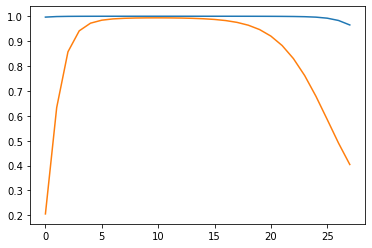

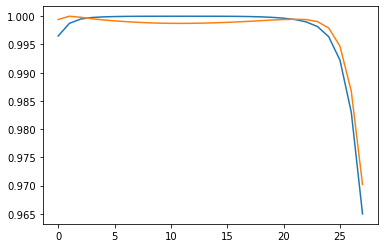

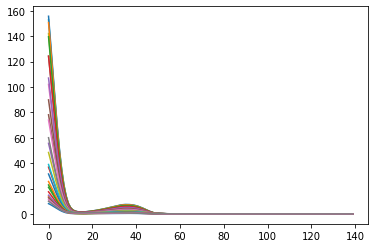

Peak at 1295 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999397735644412 
Minimum Correlation (False for <0.9): 0.964979768677959 
Minimum Correlation (True for >0.95): 0.964979768677959 
Average Correlation (True for >0.98): 0.9974275742171074 



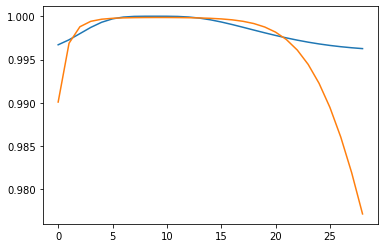

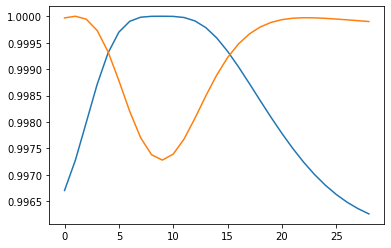

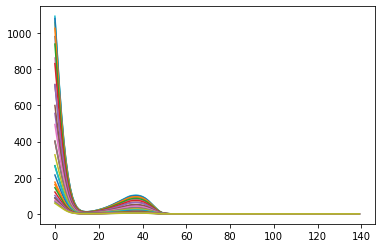

Peak at 1406 
Agilent Threshold (True for >0.9): 0.5862068965517241 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9998474211889525 
Minimum Correlation (False for <0.9): 0.996262662454429 
Minimum Correlation (True for >0.95): 0.996262662454429 
Average Correlation (True for >0.98): 0.9988086798570789 



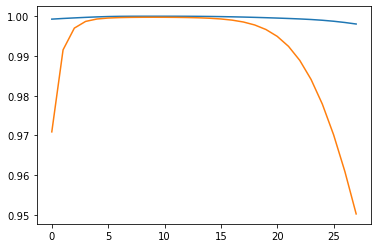

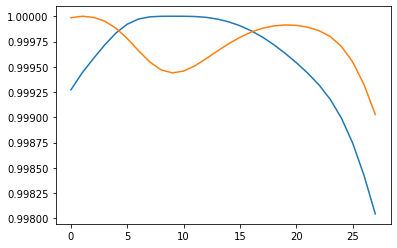

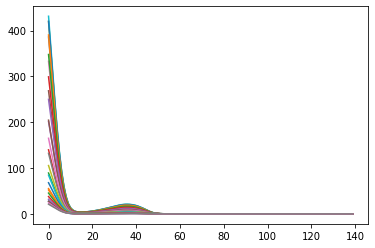

Peak at 1296 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999740128598322 
Minimum Correlation (False for <0.9): 0.9980439916746989 
Minimum Correlation (True for >0.95): 0.9980439916746989 
Average Correlation (True for >0.98): 0.9996473342383914 



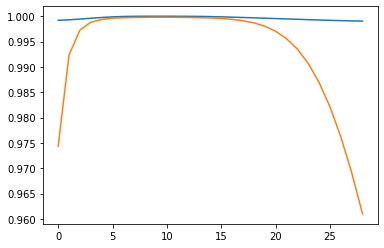

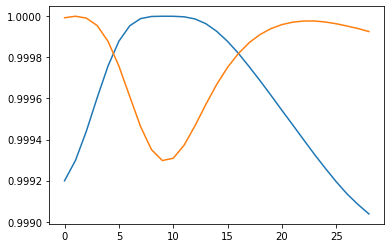

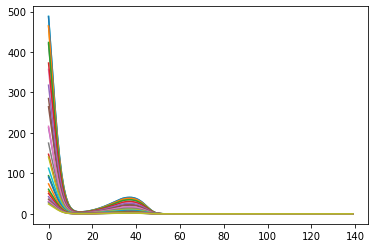

Peak at 1407 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999674922999684 
Minimum Correlation (False for <0.9): 0.9990377662204988 
Minimum Correlation (True for >0.95): 0.9990377662204988 
Average Correlation (True for >0.98): 0.9997034331777265 



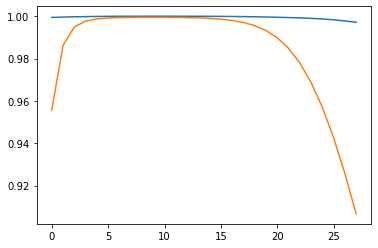

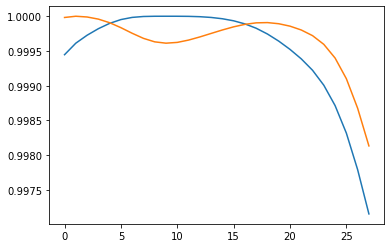

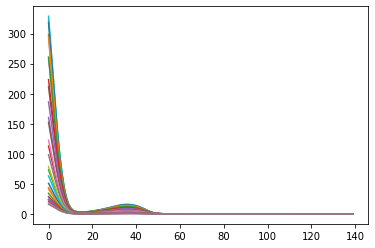

Peak at 1294 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999776918561197 
Minimum Correlation (False for <0.9): 0.9971531081496923 
Minimum Correlation (True for >0.95): 0.9971531081496923 
Average Correlation (True for >0.98): 0.9995915345952741 



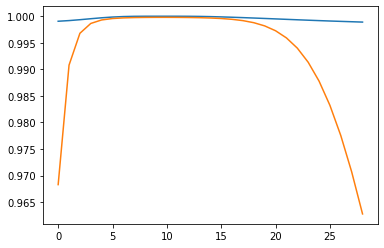

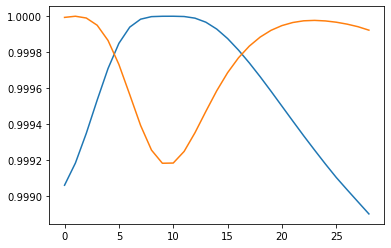

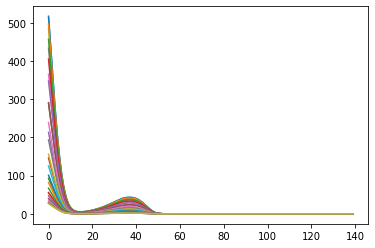

Peak at 1406 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.99996318360068 
Minimum Correlation (False for <0.9): 0.9988993353276909 
Minimum Correlation (True for >0.95): 0.9988993353276909 
Average Correlation (True for >0.98): 0.9996606356731754 



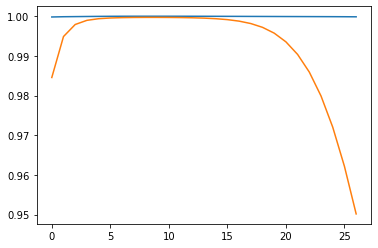

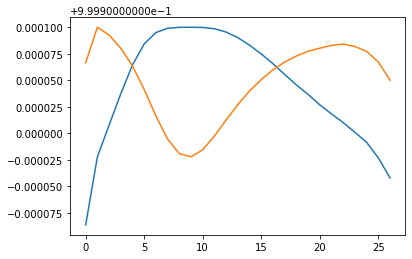

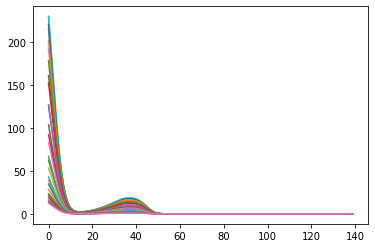

Peak at 1408 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999940606122598 
Minimum Correlation (False for <0.9): 0.9998138058992465 
Minimum Correlation (True for >0.95): 0.9998138058992465 
Average Correlation (True for >0.98): 0.9999469692243559 



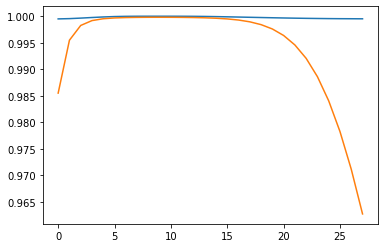

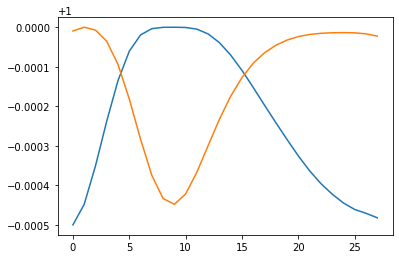

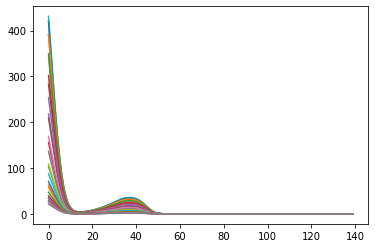

Peak at 1408 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999775323356783 
Minimum Correlation (False for <0.9): 0.9994994517479335 
Minimum Correlation (True for >0.95): 0.9994994517479335 
Average Correlation (True for >0.98): 0.999819527794279 



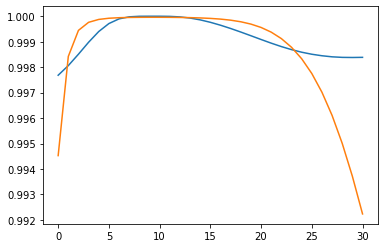

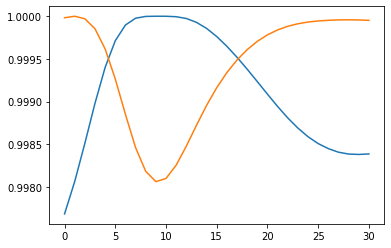

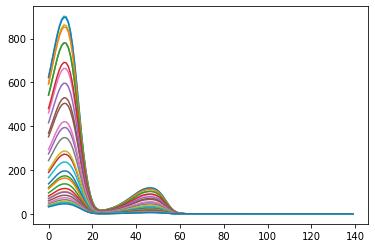

Peak at 1008 
Agilent Threshold (True for >0.9): 0.45161290322580644 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999238407022637 
Minimum Correlation (False for <0.9): 0.9976822028176303 
Minimum Correlation (True for >0.95): 0.9976822028176303 
Average Correlation (True for >0.98): 0.9992781942302864 



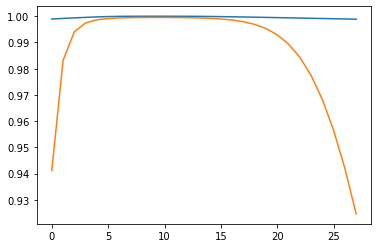

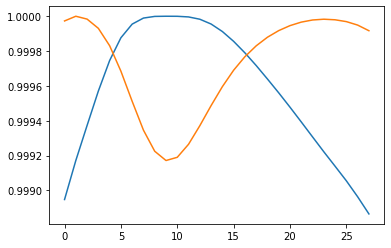

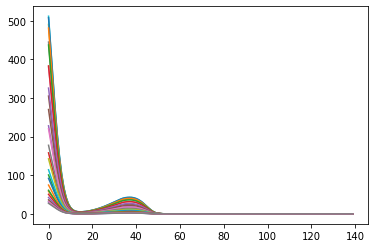

Peak at 1406 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999641187724373 
Minimum Correlation (False for <0.9): 0.9988647391026421 
Minimum Correlation (True for >0.95): 0.9988647391026421 
Average Correlation (True for >0.98): 0.9996570285023826 



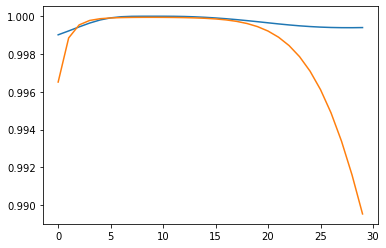

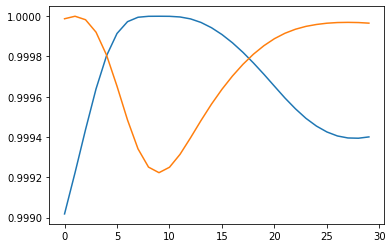

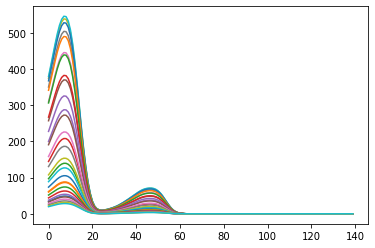

Peak at 1008 
Agilent Threshold (True for >0.9): 0.9 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999693610388092 
Minimum Correlation (False for <0.9): 0.9990178521721159 
Minimum Correlation (True for >0.95): 0.9990178521721159 
Average Correlation (True for >0.98): 0.9997105651199817 



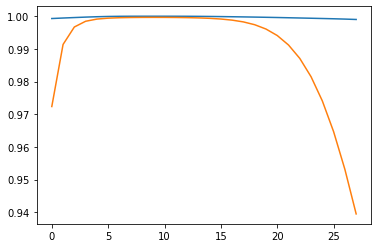

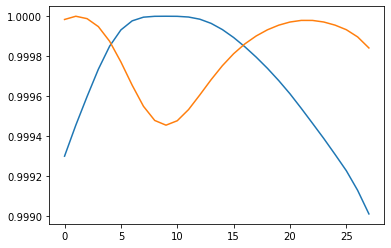

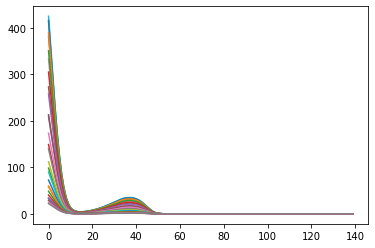

Peak at 1408 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999745244637228 
Minimum Correlation (False for <0.9): 0.999010956461437 
Minimum Correlation (True for >0.95): 0.999010956461437 
Average Correlation (True for >0.98): 0.999751728361843 



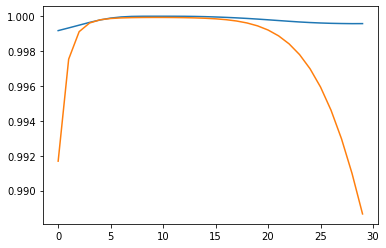

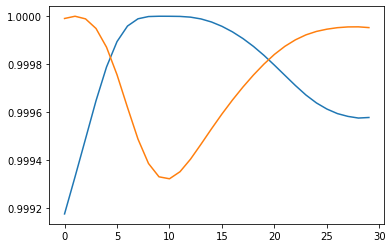

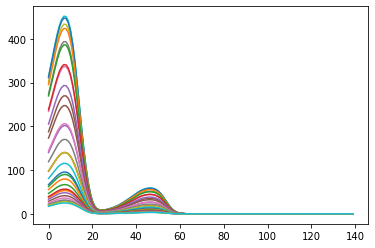

Peak at 1007 
Agilent Threshold (True for >0.9): 0.9666666666666667 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999774875061592 
Minimum Correlation (False for <0.9): 0.9991754646191231 
Minimum Correlation (True for >0.95): 0.9991754646191231 
Average Correlation (True for >0.98): 0.9997574704183357 



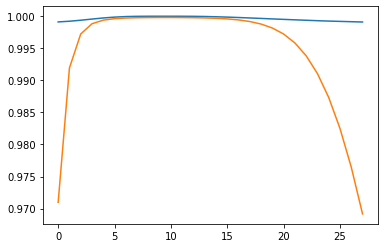

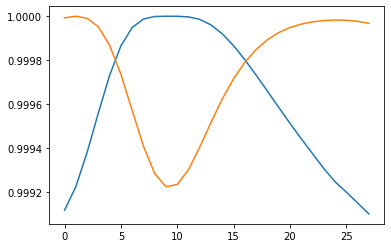

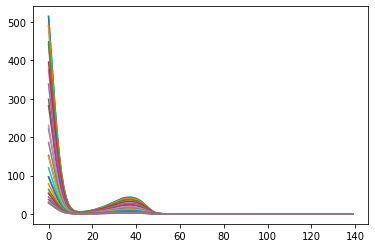

Peak at 1405 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999651562795719 
Minimum Correlation (False for <0.9): 0.9990986424447491 
Minimum Correlation (True for >0.95): 0.9990986424447491 
Average Correlation (True for >0.98): 0.999690687113192 



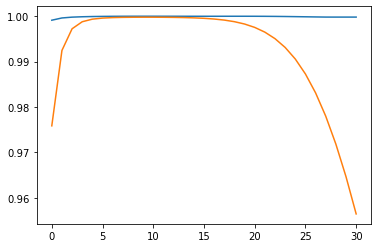

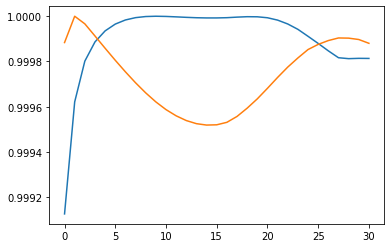

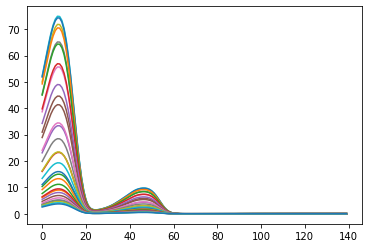

Peak at 1008 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999891014579719 
Minimum Correlation (False for <0.9): 0.9991256038189651 
Minimum Correlation (True for >0.95): 0.9991256038189651 
Average Correlation (True for >0.98): 0.9998223012412264 



/Users/haascp/opt/anaconda3/envs/mocca-dev/lib/python3.9/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


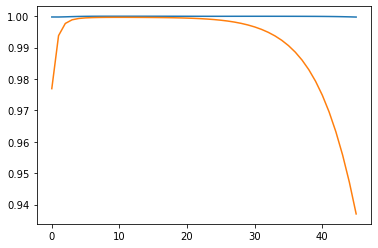

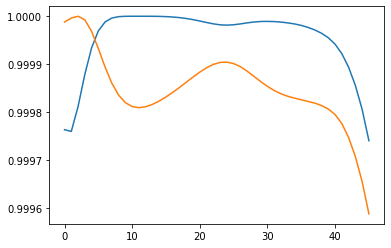

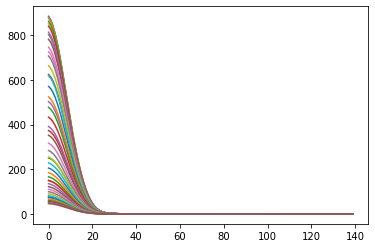

Peak at 376 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999938323828077 
Minimum Correlation (False for <0.9): 0.9995874796521562 
Minimum Correlation (True for >0.95): 0.9995874796521562 
Average Correlation (True for >0.98): 0.9999016567861583 



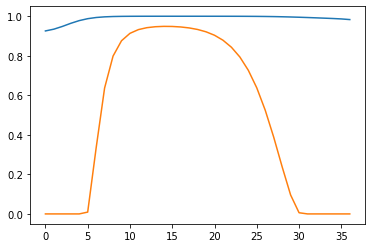

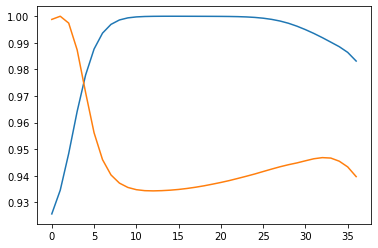

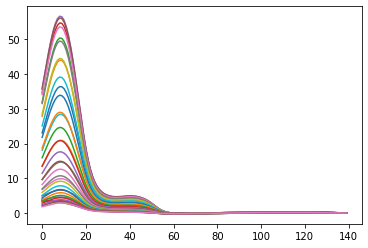

Peak at 751 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9996940033084771 
Minimum Correlation (False for <0.9): 0.9256862886561921 
Minimum Correlation (True for >0.95): 0.9256862886561921 
Average Correlation (True for >0.98): 0.9688173640075685 



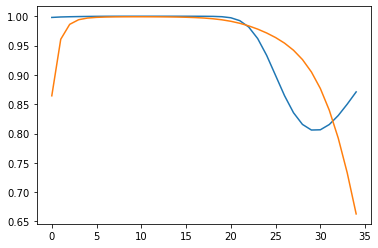

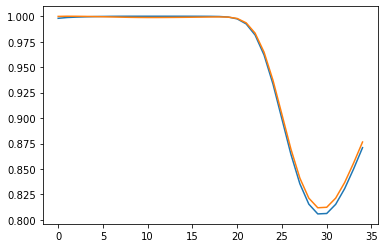

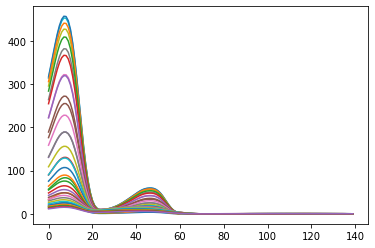

Peak at 1007 
Agilent Threshold (True for >0.9): 0.7142857142857143 
Unimodality Test (False for False): False 
PCA Variance Explained (True for >0.995): 0.998776574405213 
Minimum Correlation (False for <0.9): 0.8059107275131212 
Minimum Correlation (True for >0.95): 0.8059107275131212 
Average Correlation (True for >0.98): 0.9509355572266756 



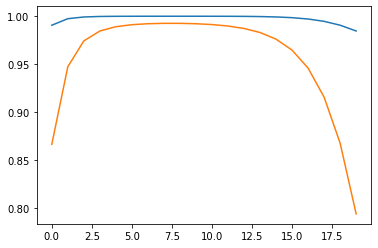

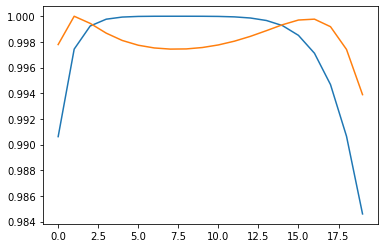

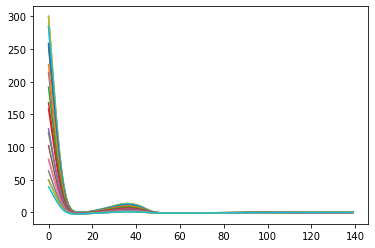

Peak at 1294 
Agilent Threshold (True for >0.9): 1.0 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9997884363633585 
Minimum Correlation (False for <0.9): 0.9845939234439126 
Minimum Correlation (True for >0.95): 0.9845939234439126 
Average Correlation (True for >0.98): 0.9978864300357337 



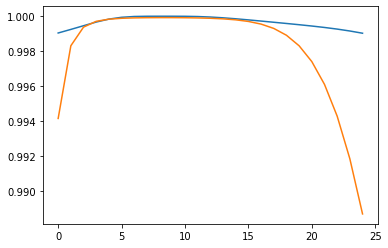

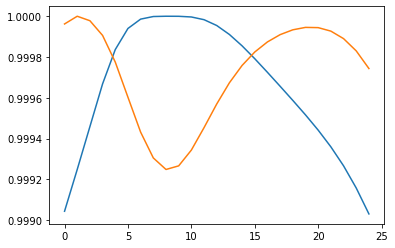

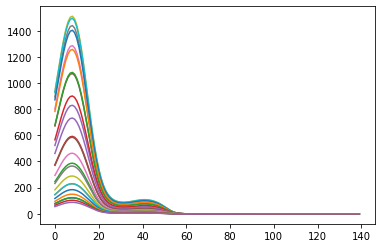

Peak at 1351 
Agilent Threshold (True for >0.9): 0.96 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9999669019835017 
Minimum Correlation (False for <0.9): 0.9990308417623809 
Minimum Correlation (True for >0.95): 0.9990308417623809 
Average Correlation (True for >0.98): 0.99969027022513 



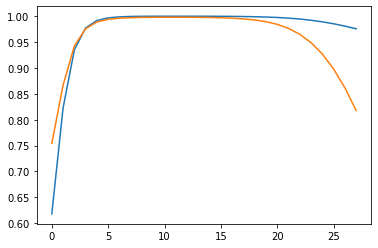

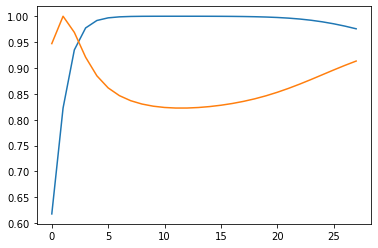

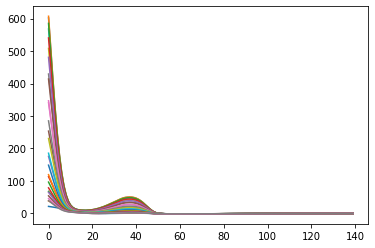

Peak at 1406 
Agilent Threshold (True for >0.9): 0.8928571428571429 
Unimodality Test (False for False): True 
PCA Variance Explained (True for >0.995): 0.9991882515271814 
Minimum Correlation (False for <0.9): 0.6179993861115541 
Minimum Correlation (True for >0.95): 0.6179993861115541 
Average Correlation (True for >0.98): 0.9202271469907419 



In [90]:
campaign.process_all_experiments(detector_limit=campaign.settings.detector_limit, wl_low_pass=None,
                                 spectrum_correl_thresh=0.9, relative_distance_thresh=0.01,
                                 wl_high_pass = 215, peaks_high_pass = 1, 
                                 peaks_low_pass = 5, absorbance_threshold = 700)

In [79]:
len(campaign.compound_chroms)

6

In [80]:
for peak in campaign.chroms[0].peaks:
    display(peak.maximum)
    display(peak.compound_id)
    display(peak.integral)
    display(peak.concentration)

376

'unknown_1'

206550.8402845089

None

751

'unknown_2'

16187.308089379052

None

1007

None

108227.6753674092

None

1294

'2-chlorotuluene'

15995.194547856316

0.03258938909374124

1351

'unknown_3'

310478.6081232501

None

1406

'tetralin'

45524.56221006884

0.030565292181505214

In [35]:
for chrom in campaign.compound_chroms:
    display(chrom.dataset.path)
    for peak in chrom.peaks:
        display(peak.compound_id)
        display(peak.integral)
        #display(peak.concentration)
        display(peak.istd)

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_96.txt'

'2-chlorotuluene'

10618.060848096951

[]

'tetralin'

90765.2642286953

[]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_88.txt'

'2-chlorotuluene'

29082.561621718694

[IstdPeak(maximum=1407, integral=37415.788129257555, offset=1, compound_id='tetralin', concentration=0.06094)]

'tetralin'

37415.788129257555

[IstdPeak(maximum=1407, integral=37415.788129257555, offset=1, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_89.txt'

'2-chlorotuluene'

22403.533720771888

[IstdPeak(maximum=1406, integral=40018.91508806365, offset=0, compound_id='tetralin', concentration=0.06094)]

'tetralin'

40018.91508806365

[IstdPeak(maximum=1406, integral=40018.91508806365, offset=0, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_92.txt'

'o-tolunitrile'

203579.565272476

[IstdPeak(maximum=1406, integral=39027.10437635546, offset=0, compound_id='tetralin', concentration=0.06094)]

'tetralin'

39027.10437635546

[IstdPeak(maximum=1406, integral=39027.10437635546, offset=0, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_93.txt'

'o-tolunitrile'

123388.0305363853

[IstdPeak(maximum=1408, integral=32509.528803783243, offset=2, compound_id='tetralin', concentration=0.06094)]

'tetralin'

32509.528803783243

[IstdPeak(maximum=1408, integral=32509.528803783243, offset=2, compound_id='tetralin', concentration=0.06094)]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_94.txt'

'o-tolunitrile'

101291.93802706029

[IstdPeak(maximum=1405, integral=39231.976970444244, offset=-1, compound_id='tetralin', concentration=0.06094)]

'tetralin'

39231.976970444244

[IstdPeak(maximum=1405, integral=39231.976970444244, offset=-1, compound_id='tetralin', concentration=0.06094)]

In [53]:
for comp in campaign.quali_comp_db.items:
    display(comp.compound_id)
    display(comp.maximum)
    display(len(comp.created_from))


'tetralin'

1406

7

'2-chlorotuluene'

1294

4

'o-tolunitrile'

1007

3

'unknown_1'

376

1

'unknown_2'

751

1

'unknown_4'

1351

1

In [19]:
for comp in campaign.quant_comp_db.items:
    display(comp.compound_id)
    display(comp.calib_factors)
    display(comp.calib_data)
    display(comp.calib_scores)
    display(len(comp.created_from))

'tetralin'

{'absolute': 1489420.15472096}

{'absolute': [(0.06094, 90765.2642286953)]}

{'absolute': nan}

1

'2-chlorotuluene'

{'absolute': 490809.8921967266, 'tetralin': 0.7806230737067894}

{'absolute': [(0.0603, 29082.561621718694), (0.04422, 22403.533720771888)],
 'tetralin': [(0.0603, 0.04736747223137285), (0.04422, 0.03411565110996862)]}

{'absolute': 0.9662250880730451, 'tetralin': 0.9971485738520937}

2

'o-tolunitrile'

{'absolute': 3237864.687574665, 'tetralin': 5.318045099264461}

{'absolute': [(0.05955, 203579.565272476),
  (0.04367, 123388.0305363853),
  (0.029775, 101291.93802706029)],
 'tetralin': [(0.05955, 0.3178851955827124),
  (0.04367, 0.23129423456953574),
  (0.029775, 0.15733927219674235)]}

{'absolute': 0.9199017630682809, 'tetralin': 0.9997418952808681}

3

In [65]:
for chrom in campaign.bad_chroms:
    display(chrom.dataset.path)

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_90.txt'

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_91.txt'

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_95.txt'

In [25]:
test = ((1, 2), (2, 4), (3, 6), (4, 8))

In [26]:
for i in zip(*test):
    print(i)

(1, 2, 3, 4)
(2, 4, 6, 8)


In [27]:
reaction_folders[81]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_85.txt'

In [22]:
stats = campaign.quant_comp_db.items[2].calib_scores
max(stats, key=lambda key: stats[key])

'tetralin'

In [24]:
"a" is 'a'

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/c_/gt8zcwrn18s1dhd756dg2srw0000gn/T/ipykernel_1926/4094855256.py:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  "a" is 'a'


True

In [64]:
reaction_folders[0]

'/Users/haascp/Documents/PostDoc/MIT/MIC-DROP/cora/cyanation/wellplate_data/full plate combined data/09072021_sample_4.txt'